In [1]:
import os
import MDAnalysis as mda
import nglview as nv
import numpy as np

use gromacs to construct the box

In [2]:
os.system('which gmx')

/usr/local/gmx2023/bin/gmx


0

In [3]:
concentrations = np.array([0.8, 1.6, 2.4, 3.2, 4.0], dtype='float64')#mol/L

In [4]:
boxvol = 6.4 * 10.0**(-23) # L
avogadro = 6.0221 * 10**(23) # 1/mol

In [5]:
moles = concentrations * boxvol
particles = moles * avogadro
particles = particles.astype('float64')
particles_rounded = np.round(particles).astype('int64')

In [6]:
particles_rounded

array([ 31,  62,  92, 123, 154])

In [ ]:
for conc in concentrations:
    os.system('mkdir {}'.format(conc,'%.1f'))

visualize and generate topology

In [ ]:
u = mda.Universe('optcoords.pdb')
uv = nv.show_mdanalysis(u)
uv.background='black'
uv

In [ ]:
ions = u.select_atoms('not resname TIP3')

In [ ]:
anions = u.select_atoms('resname MP1')

In [ ]:
cations = u.select_atoms('resname MAM')

In [ ]:
ions.write('frame0.pdb', frames=u.trajectory[:1])

In [ ]:
anions.write('mp1.pdb', frames=u.trajectory[:1])

In [ ]:
cations.write('mam.pdb', frames=u.trajectory[:1])

In [ ]:
os.system("sed -i 's/MAM /MAMM/g' frame0.pdb")
os.system("sed -i 's/MAM /MAMM/g' mam.pdb")

In [ ]:
os.system("sed -i 's/MP1 /MP_1/g' frame0.pdb")
os.system("sed -i 's/MP1 /MP_1/g' mp1.pdb")

In [ ]:
os.system('( echo 1 ; echo 1 ) | gmx pdb2gmx -f mp1.pdb -o confout_mp1.pdb -p topol_mp1.top -i posre_mp1.itp')

In [ ]:
os.system('( echo 1 ; echo 1 ) | gmx pdb2gmx -f mam.pdb -o confout_mam.pdb -p topol_mam.top -i posre_mam.itp')

In [ ]:
for conc_nr, conc in enumerate(concentrations):
    os.chdir('{}'.format(conc, '%.1f'))
    os.system('cp ../confout_mp1.pdb .')
    os.system('cp ../topol_mp1.top topol_mp1.itp')
    os.system('cp ../confout_mam.pdb .')
    os.system('cp ../topol_mam.top topol_mam.itp')
    os.system('gmx insert-molecules -ci confout_mp1.pdb -box 4 4 4 -nmol {} -o box.pdb'.format(particles_rounded[conc_nr], '%s'))
    os.system('gmx insert-molecules -f box.pdb -ci confout_mam.pdb -box 4 4 4 -nmol {} -o box.pdb'.format(particles_rounded[conc_nr], '%s'))
    os.system('touch topol.top')
    os.chdir('..')

edit topol.top in each folder: import the itps and change system name and number of mols
(example in 0.8)

edit topol_mp1.itp and topol_mam.itp and remove everything below dihedrals and above moleculetype in 0.8

...and copy them to the other folders...

In [ ]:
for conc_nr, conc in enumerate(concentrations):
    os.chdir('{}'.format(conc, '%.1f'))
    if conc_nr != 0:
        os.system('cp ../0.8/topol_mp1.itp .')
        os.system('cp ../0.8/topol_mam.itp .')
    os.chdir('..')

copy the position restraint files

In [ ]:
for conc_nr, conc in enumerate(concentrations):
    os.chdir('{}'.format(conc, '%.1f'))
    os.system('cp ../posre_mp1.itp .')
    os.system('cp ../posre_mam.itp .')
    os.chdir('..')

solvate

In [ ]:
for conc_nr, conc in enumerate(concentrations):
    os.chdir('{}'.format(conc, '%.1f'))
    os.system('gmx solvate -cp box.pdb -p topol.top -box 4 4 4 -o box_solv.pdb')
    os.chdir('..')

run an energy minimization

In [ ]:
for conc_nr, conc in enumerate(concentrations):
    os.chdir('{}'.format(conc, '%.1f'))
    os.system('cp ../em.mdp .')
    os.system("echo 'q' | gmx make_ndx -f box_solv.pdb -o system.ndx &> make_ndx.log")
    os.system('gmx grompp -f em.mdp -c box_solv.pdb -p topol.top -o em.tpr -maxwarn 1')
    os.system('gmx mdrun -deffnm em -pin on -ntmpi 1 -ntomp 3 -c em.pdb')
    os.chdir('..')

equilibrate

In [ ]:
for conc_nr, conc in enumerate(concentrations):
    os.chdir('{}'.format(conc, '%.1f'))
    os.system('cp ../nvt.mdp .')
    os.system('gmx grompp -f nvt.mdp -c em.pdb -p topol.top -o nvt.tpr -maxwarn 1')
    os.system('gmx mdrun -deffnm nvt -pin on -ntmpi 1 -ntomp 3 -c nvt.pdb')
    os.chdir('..')

extend the box:

In [ ]:
for conc_nr, conc in enumerate(concentrations):
    os.chdir('{}'.format(conc, '%.1f'))
    os.system('gmx editconf -f nvt.pdb -o elongated_box.pdb -box 4 4 10 -translate 0 0 3')
    os.chdir('..')

fill with water

In [ ]:
for conc_nr, conc in enumerate(concentrations):
    os.chdir('{}'.format(conc, '%.1f'))
    os.system('gmx solvate -cp elongated_box.pdb -p topol.top -o longbox_solv.pdb -box 4 4 10')
    os.chdir('..')

do position restraint minimization

In [ ]:
for conc_nr, conc in enumerate(concentrations):
    os.chdir('{}'.format(conc, '%.1f'))
    #os.system('cp ../em_posre.mdp .')
    os.system('gmx grompp -f em_posre.mdp -c longbox_solv.pdb -r longbox_solv.pdb -p topol.top -o em_longbox_restr.tpr -maxwarn 1')
    os.system('gmx mdrun -deffnm em_longbox_restr -pin on -ntmpi 1 -ntomp 3 -c em_longbox_restr.pdb')
    os.chdir('..')

do position restraint equilibration

In [ ]:
for conc_nr, conc in enumerate(concentrations):
    os.chdir('{}'.format(conc, '%.1f'))
    #os.system('cp ../eq_longbox.mdp .')
    os.system('gmx grompp -f eq_longbox.mdp -c em_longbox_restr.pdb -r em_longbox_restr.pdb -p topol.top -o eq_longbox_restr.tpr -maxwarn 1')
    os.system('gmx mdrun -deffnm eq_longbox_restr -pin on -ntmpi 1 -ntomp 3 -c eq_longbox_restr.pdb')
    os.chdir('..')

create ion index for flat-bottom restraints in each concentration folder

In [ ]:
for conc_nr, conc in enumerate(concentrations):
    
    os.chdir('{}'.format(conc, '%.1f'))

    for ion in range(particles_rounded[conc_nr]*2):
        
        index_groups = np.arange(1, ion+2, 1, dtype = int) #interval [1:stop) and 1 instead of 0 -> +2
        
        with open("makeindex.sh", "w") as f:
            
            f.write("gmx make_ndx -f eq_longbox_restr.pdb -o lonely_ions.ndx << EOF\n")
            
            for index in index_groups:
                
                f.write("ri "+str(index)+"\n")
                f.write("name "+str(index + 6)+" r_n_"+str(index)+str("\n"))
                
            for index in index_groups:
                
                f.write("ri "+str(index)+"\n")
            
            f.write("q\n")
            f.write("EOF")
            
            f.close()
    
    os.chdir('..')

In [ ]:
for conc_nr, conc in enumerate(concentrations):
    os.chdir('{}'.format(conc, '%.1f'))
    os.system('chmod +x *.sh')
    os.system('./makeindex.sh')
    os.chdir('..')

create the two pull sections for the mdp file

In [ ]:
for conc_nr, conc in enumerate(concentrations):
    os.chdir('{}'.format(conc, '%.1f'))
    
    for ion in range(particles_rounded[conc_nr]*2):
        
        index_groups = np.arange(1, ion+2, 1, dtype = int) #interval [1:stop) and 1 instead of 0 -> +2
        
        with open("pull_section.txt", "w") as f:
            
            f.write("pull                     = yes\n")
            f.write("pull-print-com           = yes\n")
            f.write("pull-print-ref-value     = yes\n")
            f.write("pull-print-components    = yes\n")
            f.write("pull-nstxout             = 10000\n")
            f.write("pull-nstfout             = 1\n")
            f.write("pull-xout-average        = no\n")
            f.write("pull-fout-average        = no\n")
            f.write("; Number of pull groups \n")
            f.write("pull-ngroups             = "+str(ion*2+2)+"\n")
            f.write("; Number of pull coordinates\n")
            f.write("pull-ncoords             = "+str(ion*2+2)+"\n")
            f.write("\n")
            
            for index in index_groups:

                f.write("; Group and coordinate parameters\n")
                f.write("pull-group"+str(index)+"-name         = r_"+str(index)+"\n")
                f.write("pull-coord"+str(index)+"-type         = flat-bottom\n")
                f.write("pull-coord"+str(index)+"-geometry     = direction-periodic\n")
                f.write("pull-coord"+str(index)+"-groups       = 0 "+str(index)+"\n")
                f.write("pull-coord"+str(index)+"-dim          = N N Y\n")
                f.write("pull-coord"+str(index)+"-origin       = 2.0 2.0 7.0\n")
                f.write("pull-coord"+str(index)+"-vec          = 0.0 0.0 1.0\n")
                f.write("pull-coord"+str(index)+"-init         = 0\n")
                f.write("pull-coord"+str(index)+"-rate         = 0\n")
                f.write("pull-coord"+str(index)+"-k            = 1000\n")
    
            for index in index_groups:
            
                f.write("; Group and coordinate parameters\n")
                f.write("pull-group"+str(index+ion+1)+"-name         = r_n_"+str(index)+"\n")
                f.write("pull-coord"+str(index+ion+1)+"-type         = flat-bottom-high\n")
                f.write("pull-coord"+str(index+ion+1)+"-geometry     = direction-periodic\n")
                f.write("pull-coord"+str(index+ion+1)+"-groups       = 0 "+str(index+ion+1)+"\n")
                f.write("pull-coord"+str(index+ion+1)+"-dim          = N N Y\n")
                f.write("pull-coord"+str(index+ion+1)+"-origin       = 2.0 2.0 3.0\n")
                f.write("pull-coord"+str(index+ion+1)+"-vec          = 0.0 0.0 1.0\n")
                f.write("pull-coord"+str(index+ion+1)+"-init         = 0\n")
                f.write("pull-coord"+str(index+ion+1)+"-rate         = 0\n")
                f.write("pull-coord"+str(index+ion+1)+"-k            = 1000\n")
                
            f.close()
            
    os.chdir('..')

In [ ]:
for conc_nr, conc in enumerate(concentrations):
    os.chdir('{}'.format(conc, '%.1f'))
    os.system('cp ../osmotic_30ns.txt .')
    os.system('cat pull_section.txt >> osmotic_30ns.txt')
    os.system('mv osmotic_30ns.txt osmotic_30ns.mdp')
    os.chdir('..')

setup and run the production

In [ ]:
for conc_nr, conc in enumerate(concentrations):
    os.chdir('{}'.format(conc, '%.1f'))
    os.system('gmx grompp -f osmotic_30ns.mdp -c eq_longbox_restr.pdb -p topol.top -o longbox_osmotic.tpr -n lonely_ions.ndx -maxwarn 1')
    os.chdir('..')

In [ ]:
for conc_nr, conc in enumerate(concentrations):
    os.chdir('{}'.format(conc, '%.1f'))
    os.system('gmx mdrun -deffnm longbox_osmotic -pin on -ntmpi 1 -ntomp 8 -v -c longbox_osmotic.pdb -pf osmotic_force.xvg -px osmotic_coord.xvg')
    os.chdir('..')

do pbcmol

In [ ]:
for conc_nr, conc in enumerate(concentrations):
    os.chdir('{}'.format(conc, '%.1f'))
    os.system('echo 6 | gmx trjconv -f longbox_osmotic.xtc -pbc mol -s longbox_osmotic.tpr -o longbox_osmotic_pbcmol.xtc -n lonely_ions.ndx') # group 6 is non-water
    os.chdir('..')

## Analyze

In [ ]:
os.getcwd() # show path of current workdir

In [ ]:
os.chdir('1.6') # cd into whichever folder you want to analyze

In [ ]:
os.getcwd() # make sure you're in the correct folder

use ur editor of choice to create the ionsonly.pdb (delete the waters)

In [ ]:
top = 'longbox_osmotic_ionsonly.pdb'
traj = 'longbox_osmotic_pbcmol.xtc'

In [ ]:
u = mda.Universe(top, traj)

In [ ]:
uv = nv.show_mdanalysis(u)

In [ ]:
uv

In [ ]:
uv.background = 'black'

In [ ]:
uv.clear_representations()

In [ ]:
uv.camera = 'orthographic'

In [ ]:
uv.add_representation('ball+stick', color = 'cyan', opacity = 0.2, selection = 'SOL')

In [ ]:
uv.add_representation('ball+stick', opacity = 1, selection = 'MP_1 or MAMM')

In [ ]:
uv.add_unitcell(a = 4, b=4, c=10)

add osmosis walls to visualization

In [ ]:
uv.shape.add_mesh([ 0, 0, 30, 0, 40, 30, 40, 0, 30, 0, 0, 40],
                     [ 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0])

In [ ]:
uv.shape.add_mesh([ 40, 40, 30, 0, 40, 30, 40, 0, 30, 0, 0, 40],
                     [ 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0])

In [ ]:
uv.shape.add_mesh([ 0, 0, 70, 0, 40, 70, 40, 0, 70, 0, 0, 40],
                     [ 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0])

In [ ]:
uv.shape.add_mesh([ 40, 40, 70, 0, 40, 70, 40, 0, 70, 0, 0, 40],
                     [ 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0])

if everything looks fine, CHECK FOR SUFFICIENT EQUILIBRATION. If the system is NOT sufficiently equilibrated, run a longer production sim and dump the first few ns

In [ ]:
from MDAnalysis.analysis.base import AnalysisFromFunction

In [ ]:
A = 4*4 #nm^2

In [ ]:
k = 1000 #kJ/mol/nm^2

In [ ]:
z_wall_upper = 7 #nm

In [ ]:
z_wall_lower = 3 #nm

In [ ]:
def get_coords(atomgroup):
    trajcoords = AnalysisFromFunction(lambda ag: ag.positions.copy(), atomgroup.atoms).run().results['timeseries']
    return trajcoords

In [ ]:
anion = u.select_atoms('resname MP_1')
cation = u.select_atoms('resname MAMM')

In [ ]:
anion_coords = get_coords(anion) # watch out this needs some RAM. If you don't have sufficient, rewrite the vectorized analysis code below to have MDAnalysis loop over the frames (ts) instead.
#cation_coords = get_coords(cation)

In [ ]:
mass_table_anion = [12,16,31,16,16,16,1,1,1,1] # atomic masses

In [ ]:
def calc_COM(molecule_coords, n_molecules, mass_table):
    
    extended_mass_table_atoms = mass_table * n_molecules
    extended_mass_table_3d = np.tile(extended_mass_table_atoms, (3,1)).T
    extended_mass_table = np.tile(extended_mass_table_3d, (molecule_coords.shape[0],1,1))
    
    mass_coords = molecule_coords * extended_mass_table
    
    COM = np.zeros((len(molecule_coords),n_molecules,3))
    
    for molecule in range(n_molecules):
        mol_com = np.sum(mass_coords[:,(molecule+1)*10-10:(molecule+1)*10,:], axis=1) / np.sum((mass_table))
        COM[:,molecule,:] = mol_com
    
    return COM

In [ ]:
n_molecules = 23 # change according to actual concentration, this is 0.8 from the examples above 

In [ ]:
anion_coms = calc_COM(anion_coords, n_molecules, mass_table_anion)

In [ ]:
def find_trespassers(reduced_coords, z_wall_upper, z_wall_lower):
    
    z_mask_upper = (reduced_coords[:,:,-1] > z_wall_upper*10) #angström
    z_mask_lower = (reduced_coords[:,:,-1] < z_wall_lower*10) #angström
        
    no_of_trespassers_upper = np.sum((z_mask_upper), axis=1)
    no_of_trespassers_lower = np.sum((z_mask_lower), axis=1)
    
    return no_of_trespassers_upper, no_of_trespassers_lower

In [ ]:
tressp_upper, tressp_lower = find_trespassers(anion_coms, z_wall_upper, z_wall_lower)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.scatter(np.arange(0,len(anion_coords),1), tressp_upper, label ='tresspassers_upper') 
plt.xlabel('frames')
plt.legend()
plt.show()
plt.close()

In [ ]:
plt.scatter(np.arange(0, len(anion_coords), 1), tressp_lower, label ='tresspassers_lower') 
plt.xlabel('frames')
plt.legend()
plt.show()
plt.close()

In [ ]:
z_mask_upper = (anion_coms[:,:,-1] > z_wall_upper*10)

In [ ]:
z_mask_lower = (anion_coms[:,:,-1] < z_wall_lower*10)

In [ ]:
def calc_z_dist(reduced_z_coords, no_of_trespassers_upper, no_of_trespassers_lower, z_mask_upper, z_mask_lower, z_wall_upper, z_wall_lower):
    z_dist_list = []
    
    for frame_no, frame in enumerate(reduced_z_coords[:]):
        if no_of_trespassers_upper[frame_no] > 0:
            #print('upper')
            z_coords_upper = frame[z_mask_upper[frame_no]][0]
            #print(z_coords_upper)
            #print(z_wall_upper*10)
            z_dist = z_coords_upper - (z_wall_upper*10)
            #print(z_dist)
            z_dist_list.append(z_dist)
            
        elif no_of_trespassers_lower[frame_no] > 0:
            z_coords_lower = frame[z_mask_lower[frame_no]][0]
            z_dist = np.abs(z_coords_lower - z_wall_lower*10)
            z_dist_list.append(z_dist)
            
        elif (no_of_trespassers_upper[frame_no] > 0 & no_of_trespassers_lower[frame_no] > 0) == True:
            z_coords_upper = frame[z_mask_upper[frame_no]][0]
            z_dist_upper = np.abs(z_coords_upper - z_wall_upper*10)
            z_dist_list.append(z_dist_upper)
            
            z_coords_lower = frame[z_mask_lower[frame_no]][0]
            z_dist_lower = np.abs(z_coords_lower - z_wall_lower*10)
            z_dist_list.append(z_dist_lower)
    
    return z_dist_list

In [ ]:
z_dist_list = np.array(calc_z_dist(anion_coms[:,:,-1], tressp_upper[:], tressp_lower[:], z_mask_upper[:], z_mask_lower[:], z_wall_upper, z_wall_lower))

In [ ]:
z_dist_list/10 # convert to nm

In [ ]:
P_osmotic = ((1/(len(anion_coords))) * k * np.sum(z_dist_list/10)) / A

In [ ]:
P_osmotic # kJ/mol/nm³

convert to SI units (Pascal)

In [77]:
osm_press_si = []
for sys,osm_value in enumerate(P_osmotic):
    op_Pa = (osm_value * 10**30) * (teilchen_rounded[sys]/avogadro) # Pa
    osm_press_si.append(op_Pa)

In [ ]:
osm_press_si # Pa

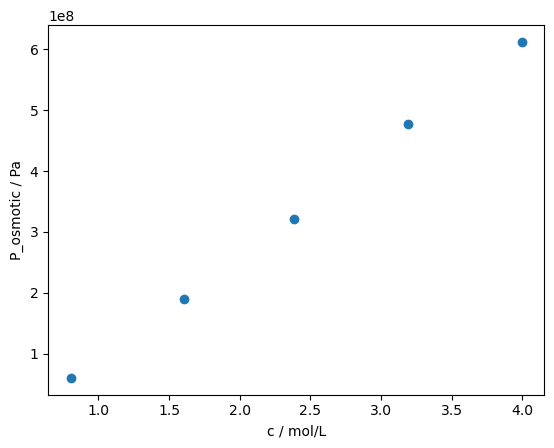

In [79]:
plt.scatter(concentrations, osm_press_si)
plt.xlabel('c / mol/L')
plt.ylabel('P_osmotic / Pa')
plt.savefig('p_osm.png')

In [80]:
plt.close()

## Check for convergence/equilibration

In [ ]:
frame_intervals = np.arange(0,len(anion_coords),5000) # whichever interval size suits you

In [ ]:
P_osmotic_intervals = []
for frames_i_nr, frames_interval in enumerate(frame_intervals):
    try: 
        z_dist_list = np.array(calc_z_dist(anion_coms[frames_interval:frame_intervals[frames_i_nr+1],:,-1], tressp_upper[frames_interval:frame_intervals[frames_i_nr+1]], tressp_lower[frames_interval:frame_intervals[frames_i_nr+1]], z_mask_upper[frames_interval:frame_intervals[frames_i_nr+1]], z_mask_lower[frames_interval:frame_intervals[frames_i_nr+1]], z_wall_upper, z_wall_lower))
        P_osmotic = ((1/(len(anion_coords)/(len(frame_intervals)-1))) * k * np.sum(z_dist_list/10)) / A
        P_osmotic_intervals.append(P_osmotic)
    except: IndexError
        

In [ ]:
P_osmotic_intervals

In [ ]:
np.arange(0,len(anion_coords),5000)

In [ ]:
plt.scatter(np.arange(5000,len(anion_coords),5000), P_osmotic_intervals)

In [ ]:
frame_intervals = np.arange(0, len(anion_coords), 5000)

In [ ]:
P_osmotic_intervals = []
for frames_i_nr, frames_interval in enumerate(frame_intervals):
    try: 
        z_dist_list = np.array(calc_z_dist(anion_coms[frames_interval:frame_intervals[frames_i_nr+1],:,-1], tressp_upper[frames_interval:frame_intervals[frames_i_nr+1]], tressp_lower[frames_interval:frame_intervals[frames_i_nr+1]], z_mask_upper[frames_interval:frame_intervals[frames_i_nr+1]], z_mask_lower[frames_interval:frame_intervals[frames_i_nr+1]], z_wall_upper, z_wall_lower))
        P_osmotic = ((1/(len(anion_coords)/(len(frame_intervals)-1))) * k * np.sum(z_dist_list/10)) / A
        P_osmotic_intervals.append(P_osmotic)
    except: IndexError
        

In [ ]:
len(P_osmotic_intervals)

In [ ]:
np.arange(5000,len(anion_coords),5000).shape

In [ ]:
plt.scatter(np.arange(5000,len(anion_coords),5000), P_osmotic_intervals)

looks homogeneous? Nice. If not, run longer production sim and dump the inhomogeneous part for analysis